<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Загрузка-датасета-и-ресемплирование" data-toc-modified-id="Загрузка-датасета-и-ресемплирование-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка датасета и ресемплирование</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Seasonal-decompose" data-toc-modified-id="Seasonal-decompose-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Seasonal decompose</a></span></li><li><span><a href="#Train,-test" data-toc-modified-id="Train,-test-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Train, test</a></span></li><li><span><a href="#Pipelines" data-toc-modified-id="Pipelines-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Pipelines</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#DecisionTree" data-toc-modified-id="DecisionTree-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>DecisionTree</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LightGBM</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2> 

<b>Все отлично!👍:</b> 
    
Вижу твое добавленное описание проекта. Молодец! Это поможет тебе расставлять акценты в выводах

In [1]:
pip install pandas_profiling

Note: you may need to restart the kernel to use updated packages.


## Подготовка

### Imports

In [2]:
import pandas as pd
from pandas_profiling import ProfileReport
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import seaborn as sb
import  matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV,TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/tmp/ipykernel_167/36845763.py:2: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


### Загрузка датасета и ресемплирование

In [3]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Отлично, что проведено ресемплирование с использованием суммы. Полученная информация поможет нам в дальнейшем с предобработкой данных

## Анализ

In [5]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- В датасете присутствует 4.9 процентов дупликатов
- В датасете есть аномальные значения, которые выходят за 1 и 99 квантили соотвественно 
- В датасете отсуствуют пропуски 
- Среднее значение в 84 и стандартное отклонение в 26 единиц

### Seasonal decompose

In [6]:
dcm = seasonal_decompose(data)

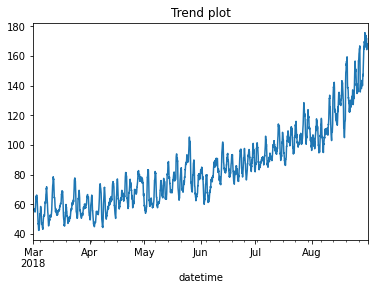

In [7]:
dcm.trend.plot()
plt.title('Trend plot')
plt.show() # по линии тренда видно, что заказы такси увеличиваются с каждым месяцем, нет зависимости от времени года

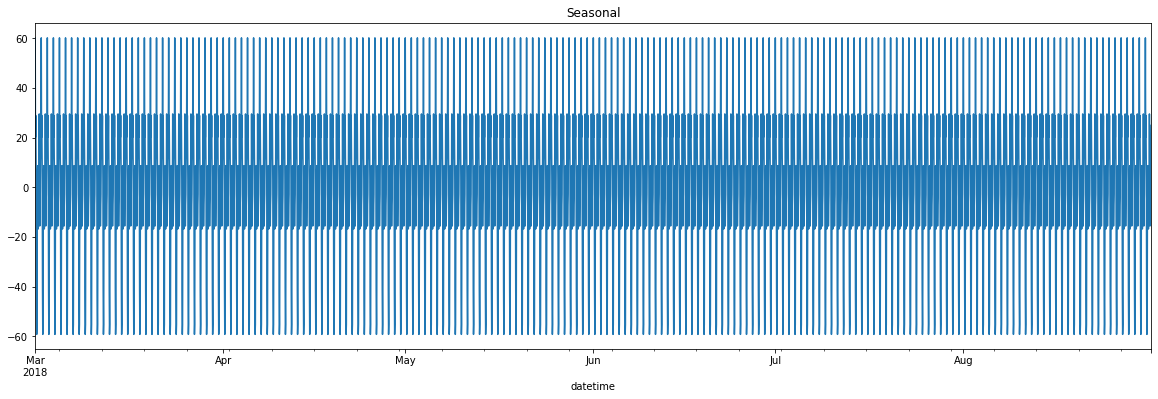

In [8]:
dcm.seasonal.plot(figsize = (20,6))
plt.title('Seasonal')
plt.show() # по графику можно понять , что сезонность не влияет

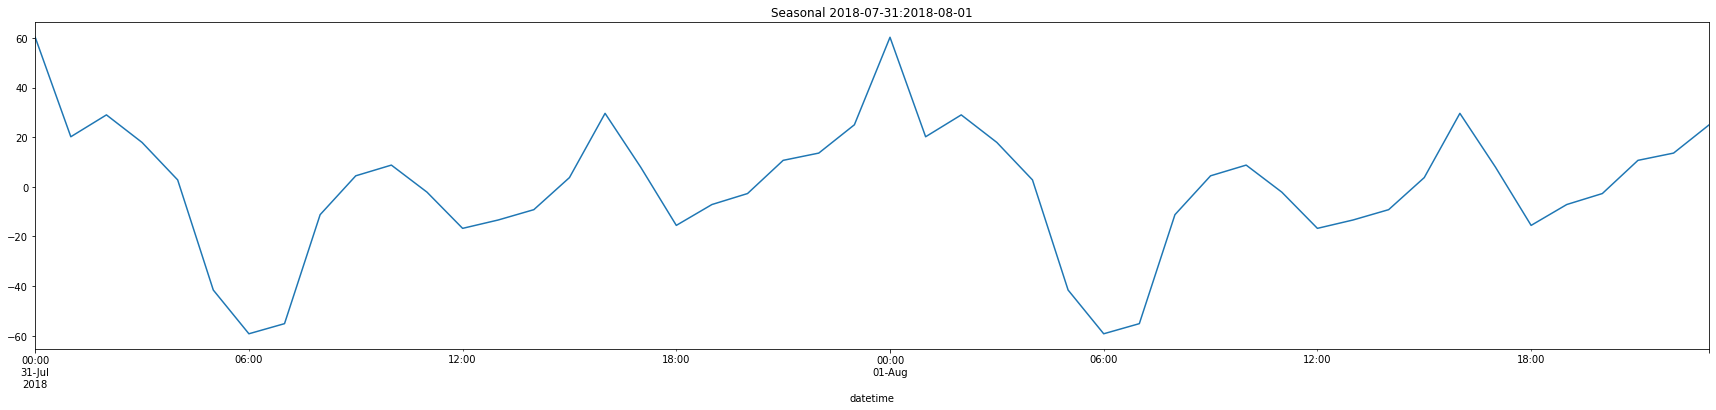

In [9]:
dcm.seasonal['2018-07-31':'2018-08-1'].plot(figsize = (30,6))
plt.title('Seasonal 2018-07-31:2018-08-01')
plt.show() # если построить сезонность по дню, то можно заметить, что такси вызывают неравномерно, ночью и днем большенство

### Train, test

In [10]:
def make_features(data, max_lag:int, rolling_mean_size:int): 
    A = data.copy()
    A['year'] = data.index.year
    A['month'] = data.index.month
    A['day'] = data.index.day
    A['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        A['lag_{}'.format(lag)] = A['num_orders'].shift(lag)
        
    A['rolling_mean'] = A['num_orders'].shift().rolling(rolling_mean_size).mean()
    return A

In [11]:
data_copy = make_features(data,24,10) # rolling_mean = 10, самое частное значение в трейдинге, другого обьяснения не могу представить
data_copy

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,173.3
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,166.6
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,162.9


In [12]:
train ,test = train_test_split(data_copy, test_size = 0.1, shuffle = False, random_state = 42)
train = train.dropna()

In [13]:
features_train = train.drop('num_orders',axis =1)
features_test = test.drop('num_orders',axis = 1)
target_train = train['num_orders']
target_test = test['num_orders']
features_train.head()

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,61.7
2018-03-02 01:00:00,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,65.9
2018-03-02 02:00:00,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,71.3
2018-03-02 03:00:00,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,74.5
2018-03-02 04:00:00,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,76.5


### Pipelines

In [15]:
p2 = Pipeline(steps = [('PCA',PCA),('Scaler',StandardScaler()),('decisiontreeregressor' , DecisionTreeRegressor())])
p_2 = make_pipeline(StandardScaler(),DecisionTreeRegressor())

In [16]:
p3 = Pipeline(steps = [('PCA', PCA), ('Scaler',StandardScaler()),('random forest regressor',RandomForestRegressor())])
p_3 = make_pipeline(StandardScaler(),RandomForestRegressor())

In [17]:
p_4 = make_pipeline(StandardScaler(), LGBMRegressor())

In [18]:
pca = PCA() 

In [19]:
def pca_graph(grid_results,features_train =features_train) -> None:
    pca.fit(features_train)
    fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
    ax0.plot(
        np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, "+", linewidth=2
    )
    ax0.set_ylabel("PCA explained variance ratio")

    ax0.axvline(
        grid_results.best_estimator_.named_steps["pca"].n_components,
        linestyle=":",
        label="n_components chosen",
    )
    ax0.legend(prop=dict(size=12))

    results = pd.DataFrame(grid_results.cv_results_)
    components_col = "param_pca__n_components"
    best_clfs = results.groupby(components_col).apply(
        lambda g: g.nlargest(1, "mean_test_score")
    )

    best_clfs.plot(
        x=components_col, y="mean_test_score", yerr="std_test_score", legend=False, ax=ax1
    )
    ax1.set_ylabel("Classification accuracy (val)")
    ax1.set_xlabel("n_components")
    plt.xlim(-1, 70)
    plt.tight_layout()
    plt.show()

In [20]:
ts_cv = TimeSeriesSplit(n_splits =3)

## Обучение

In [21]:
def fit_transfsorm(pipeline,grid_params, features_train = features_train ,
                 features_test = features_test, 
                 target_train = target_train,
                 target_test = target_test
                ) -> None:
        gridcv = RandomizedSearchCV(pipeline,grid_params,n_jobs = -1, cv = ts_cv,scoring = 'neg_root_mean_squared_error')
        gridcv.fit(features_train, target_train)
        predictions = gridcv.predict(features_train)
#         pca_graph(gridcv.best_params_)
#         print('Best mse for {} is {}'.format(pipeline,mean_squared_error(predictions,target_train,squared = False)))
        print('best result for {} is {} for params {}'.format(pipeline,-gridcv.best_score_ ,gridcv.best_params_))
#         print(gridcv.best_params_) 

### DecisionTree

In [26]:
params_d = {'decisiontreeregressor__min_samples_split':[2,3,4,5,7,9,10],
            'decisiontreeregressor__min_samples_leaf' :[2,3,4,5,7,9,10]   
}

In [27]:
fit_transfsorm(p_2,params_d)

best result for Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeregressor', DecisionTreeRegressor())]) is 31.63600466600771 for params {'decisiontreeregressor__min_samples_split': 10, 'decisiontreeregressor__min_samples_leaf': 10}


### LightGBM

In [34]:
params_gbm  = dict(lgbmregressor__num_leaves = [i for i in range(10,80,10)],
                  lgbmregressor__max_depth = [i for i in range(1,10)]
                  )

In [35]:
fit_transfsorm(p_4,params_gbm)

best result for Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmregressor', LGBMRegressor())]) is 27.02010645299804 for params {'lgbmregressor__num_leaves': 10, 'lgbmregressor__max_depth': 8}


### RandomForestRegressor

In [39]:
params_RFR = dict(randomforestregressor__max_features = ['sqrt', 'log2'],
                  randomforestregressor__min_samples_leaf = [i for i in range(2,13)])
params_RFR

{'randomforestregressor__max_features': ['sqrt', 'log2'],
 'randomforestregressor__min_samples_leaf': [2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12]}

In [40]:
fit_transfsorm(p_3,params_RFR)

best result for Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor', RandomForestRegressor())]) is 27.804480294130624 for params {'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'log2'}


### Итоги выбора моделей

Самой эффективной оказалась RandomForestRegressor с rmse = 11, поэтому будем тестировать ее

## Тестирование

{'randomforestregressor__min_samples_leaf': 3, 'randomforestregressor__max_features': 'auto'}

In [44]:
def RandomForestRegressor_l(min_samples_leaf:int,max_features,) -> float:
    model = RandomForestRegressor(
                                  min_samples_leaf = min_samples_leaf,
                                  max_features = max_features
                                 )
    model.fit(features_train ,target_train)
    predictions = model.predict(features_test)
    return (mean_squared_error(predictions,target_test,squared = False))

In [45]:
RandomForestRegressor_l(3,'log2') # rmse < 48, задание выполнено

45.17594570945421

### Conclusion

- Загрузили данные,засемплировали данные по дню, сделали фичуры
- Сделали обзор данных, пропусков - нет, зато были повторения
- Посмотрели три композитных модели: Lightgbm,DecisionTree,RandomForestRegressor
- Лучший результат показала RandomForestRegressor на тренировочной выборке (27)
- Проверили модель на тестовой и получили удобоваримый результат 46